In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import scipy.optimize as optimize


# sns.set(font_scale=1.6, palette='summer')
sns.set(font_scale=1.6, palette='Set2')


%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as skRegression
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE

In [15]:
def CAMNS(C, d, L, N=3, method='SLSQP'):
    l = 0
    B = np.eye(L)

    while l != N:
        w = sps.norm().rvs(size=L)
        r = B @ w

        def fmin(alpha):
            return r @ (d.flatten() + C@alpha)
        def fmax(alpha):
            return -fmin(alpha)
        
        constraint = optimize.LinearConstraint(C, lb=-d.flatten(), ub=np.ones(C.shape[0]) * np.inf)
        guess = np.zeros(N - 1)
        a1 = optimize.minimize(fmin, 
                                   x0=guess,
                                   method=method,
                                   constraints=constraint).x

        a2 = optimize.minimize(fmax, 
                                   x0=guess,
                                   method=method,
                                   constraints=constraint).x

        if l == 0:
            S = np.vstack((C @ a1 + d.T, C @ a2 + d.T)).T
        else:
            nw = None
            if np.linalg.norm(fmin(a1)) != 0:
                nw = C @ a1 + d.T
            elif np.linalg.norm(fmin(a2)) != 0:
                nw = C @ a2 + d.T
            S = np.hstack((S, nw.reshape(-1, 1)))
        l = S.shape[1]

        q, r = np.linalg.qr(S)
        B = np.eye(L) - q @ q.T 
    
    return S

In [3]:
def fit_affine(X, N=3):
    d = X.mean(axis=1).reshape(-1, 1)
    U = X - d @ np.ones(shape=(1, X.shape[1]))
    # по-честному оно выглядит так
    # w, v = np.linalg.eig(U @ U.T)
    # C = v[:, :N-1]
    # с такой реализацией оно работает бесконечно долго,
    # а мы люди занятые, поэтому используем пРиБлиЖеНиЕ
    C = U[:, :N-1]
    return C, d

In [4]:
def draw_cool_guys(matrix, title='Красавцы'):
    plt.figure(figsize=(15, 9))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(matrix[:, i].reshape(128, 128), cmap='gray')
    plt.suptitle(title, fontsize=24, va='bottom', y=0.75)
    plt.show()

In [5]:
names = ['cao1.jpg', 'ksiwek1.jpg', 'zhang1.jpg']
imgs = np.array([plt.imread(name) for name in names])

imgs_flat = np.array([img.flatten() for img in imgs])

weights = np.array([
    [0.4, 0.1, 0.2],
    [0.3, 0.3, 0.2],
    [0.3, 0.6, 0.6]
])

mix = imgs_flat.T @ weights

In [6]:
def mutate_and_back(matrix, weight):
    draw_cool_guys(matrix, 'Оригинал')
    mutant = matrix @ weights
    draw_cool_guys(mutant, 'Испорченные')
    C, d = fit_affine(mutant)
    fixed = CAMNS(C, d, mutant.shape[0])
    draw_cool_guys(fixed, 'Исправленные')

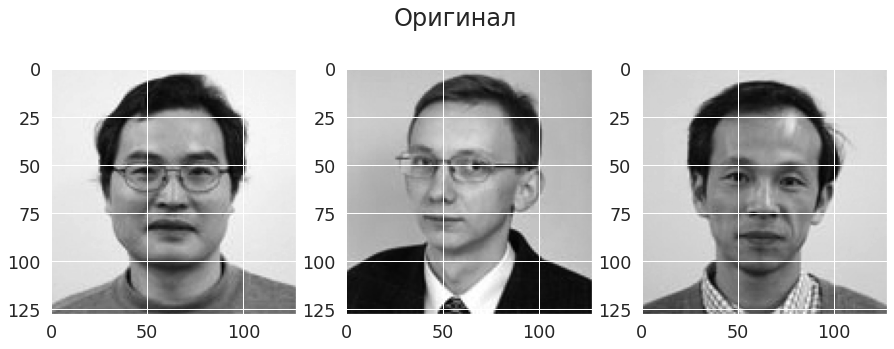

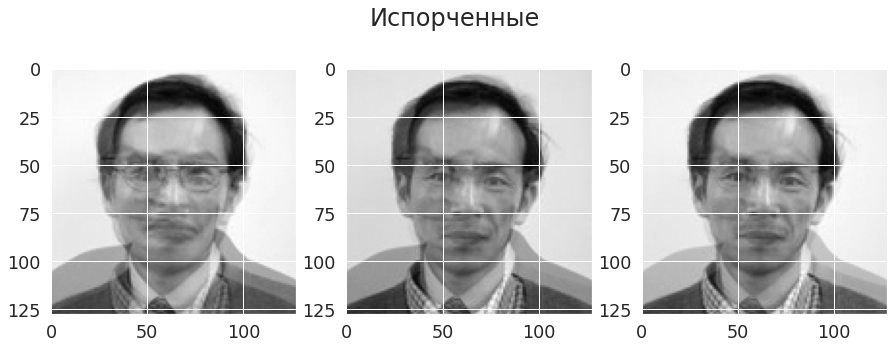

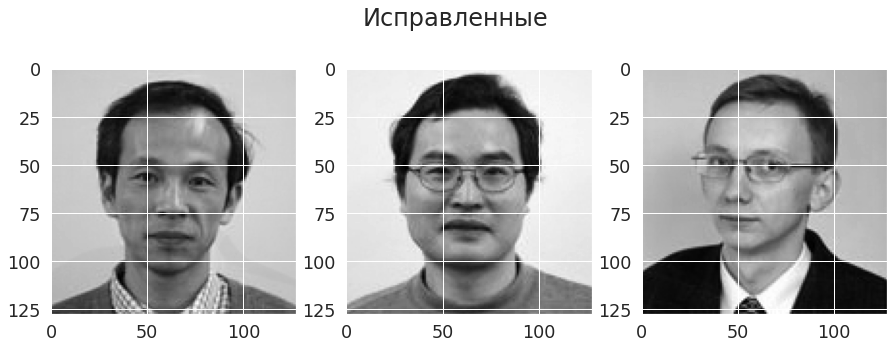

In [17]:
mutate_and_back(imgs_flat.T, weights)

Ну в целом видим, что работает.
Теперь проверим, как влияет метод решения оптимизационной подзадачи.

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


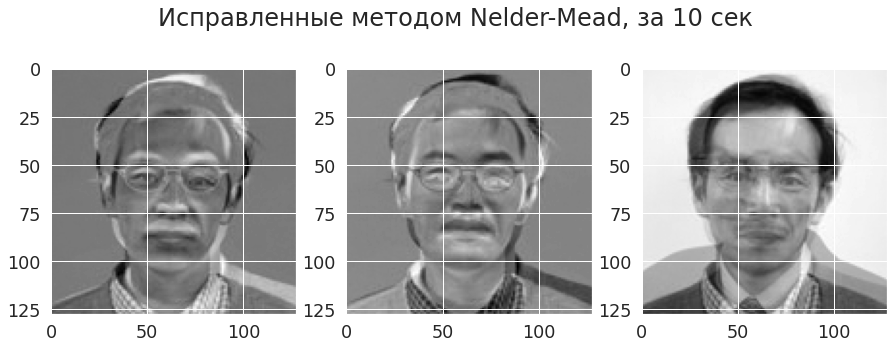

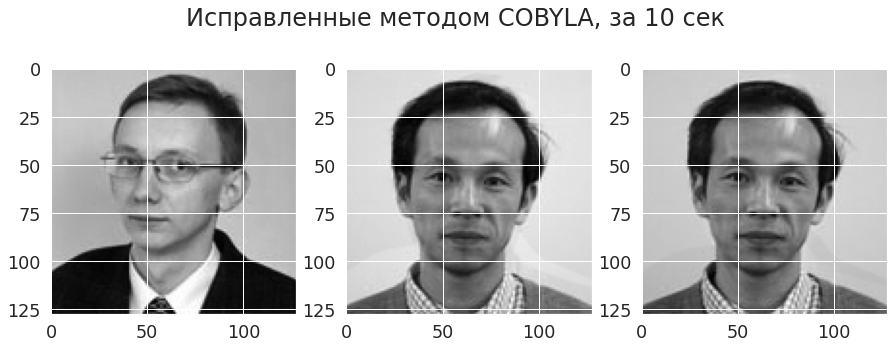

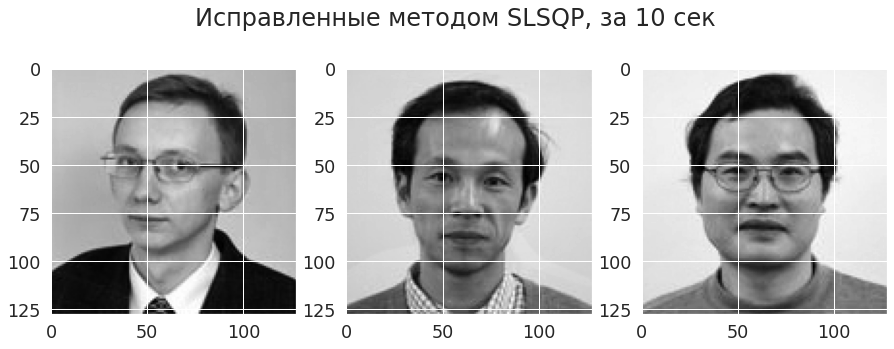

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:525: RuntimeWarning: Method TNC cannot handle constraints.
  RuntimeWarning)


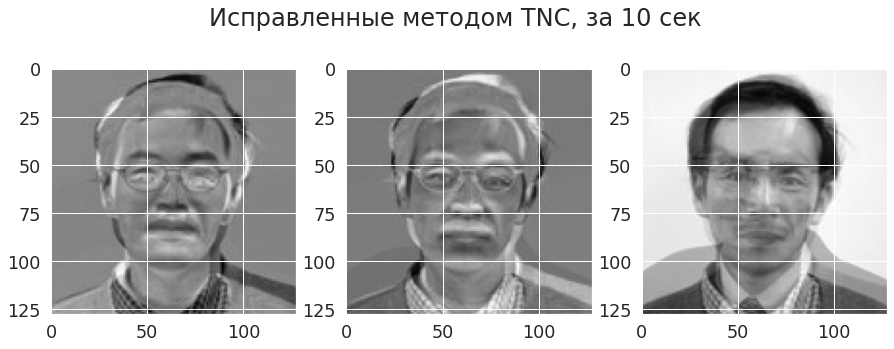

In [11]:
method = ['Nelder-Mead', 'COBYLA', 'SLSQP', 'TNC']
mutant = imgs_flat.T @ weights
C, d = fit_affine(mutant)
for met in method:
    start = time.time()
    fixed = CAMNS(C, d, mutant.shape[0], method=met)
    finish = time.time()
    draw_cool_guys(fixed, f'Исправленные методом {met}, за {round(finish - start)} сек')

Часть методов нам не доступна по различным причинам, в частности мы увидели, что методы, которые не переваривают ограничения на коэффициенты, сильно проигрывают в качестве(а TNC еще и по времени).

COBYLA и SLSQP работают одинаково быстро и качественно, респект таким методам.

Из недостатков иногда получаются одинаковые лица в ответе, у нас все-таки недетерминированный алгоритм, грустная ситуация.

Теперь проверим, что различные веса ничего не портят.

матрица весов [[0.267 0.238 0.414]
 [0.466 0.454 0.376]
 [0.267 0.308 0.21 ]]


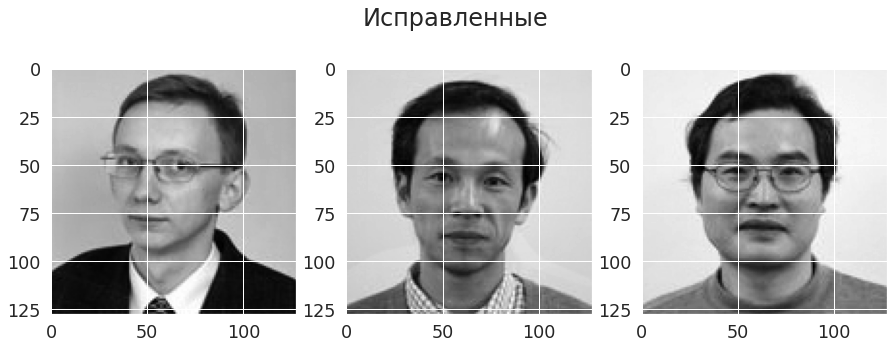

матрица весов [[0.271 0.174 0.401]
 [0.426 0.434 0.327]
 [0.303 0.392 0.271]]


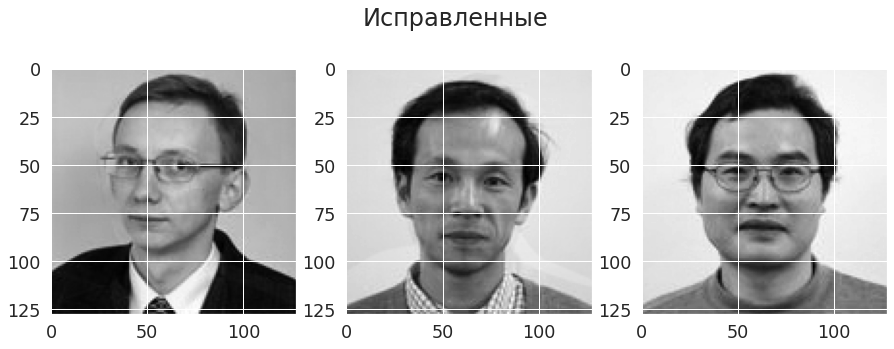

матрица весов [[ 0.237  0.411  0.534]
 [ 0.383  0.347  0.48 ]
 [ 0.38   0.242 -0.013]]


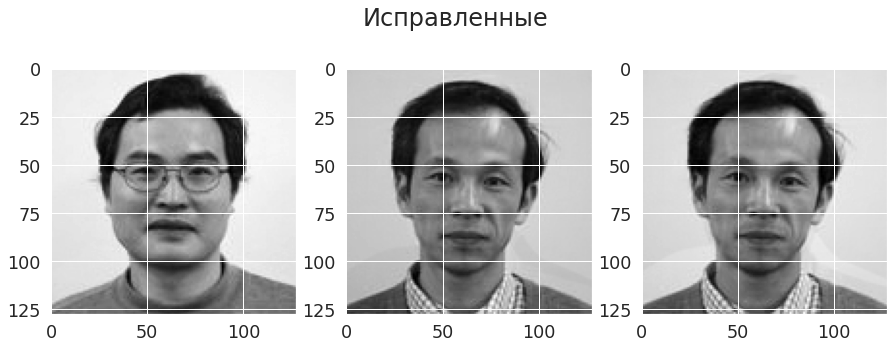

матрица весов [[0.329 0.401 0.274]
 [0.329 0.314 0.48 ]
 [0.342 0.285 0.246]]


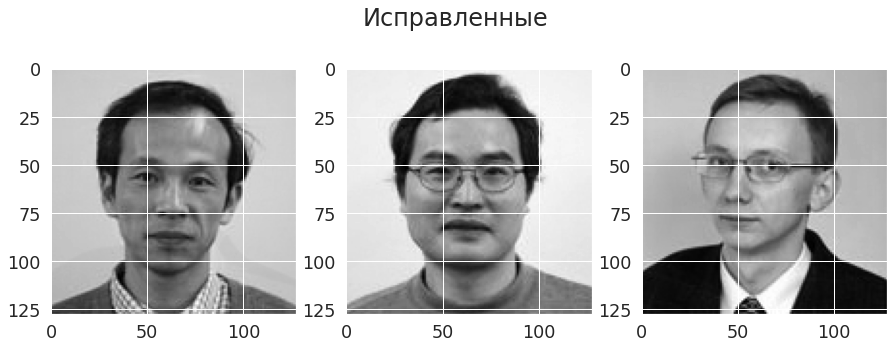

In [12]:
for _ in range(4):
    w = sps.norm(loc=3, scale=1).rvs(size=(3, 3)) # чтобы было положительным
    for j in range(3):
        avg = np.sum(w[:, j])
        w[:, j] = w[:, j] / avg
    print('матрица весов', np.around(w, 3))
    mutant = imgs_flat.T @ w
    C, d = fit_affine(mutant)
    fixed = CAMNS(C, d, mutant.shape[0])
    draw_cool_guys(fixed, f'Исправленные')

***Общий вывод***

Зачем-то иногда получаются одинаковые лица в ответе, но как видим редко.

При этом в общем увидели, что метод рабочий. Подкручивать его не так сложно, даже встроенные методы оптимизации внутри достаточно неплохо работают.

Из недостатков - в оригинальной статье приводился метод нахождения C, d, который работает на наших входных данных неприемлемо долго. Пришлось подстроиться.